# DATA EXTRACTION

In [23]:
import retrieve_data_allsp
import pandas as pd
import os

## EXTRACTION OF ANNOTATIONS COMING FROM UNIPROT

In [3]:
wd = "/cluster/gjb_lab/2394007/def_data_retrieval"                                 # WORKING DIRECTORY

taxids_dict = retrieve_data_allsp.get_tax_ids_dict(wd, download = False)          # 13875 ENTRIES. DICTIONARY MAPS TAXONOMIC IDS TO SPECIES MNEMONICS
accs_ids_dict = retrieve_data_allsp.get_accs_tax_ids_dict(wd, download = False)   # 561911 ENTRIES. DICTIONARY MAPS PROTEIN ACCESSIONS TO TAXONOMIC IDS

up = retrieve_data_allsp.retrieve_uniprot(wd, "ANK", download = True)             # "ANK" REPRESENTS UNIPROT REPEAT FAMILY KEYWORD. up IS A DATAFRAME CONTAINING UNIPROT ANK ANNOTATIONS

Server response was OK, code 200


In [32]:
up.head()

,accession,source,start,end,length,repeat_id
0,P0C9U1,Uniprot,54,83,525,P0C9U1/54-83
1,P0C9U1,Uniprot,129,158,525,P0C9U1/129-158
2,P0C9U1,Uniprot,261,291,525,P0C9U1/261-291
3,P0C9U1,Uniprot,324,351,525,P0C9U1/324-351
4,P0C9M4,Uniprot,61,93,356,P0C9M4/61-93


In [18]:
{k: taxids_dict[k] for k in list(taxids_dict)[:10]}

{11788: 'MLVAB',
 45372: 'ABIAL',
 90345: 'ABIBA',
 66168: 'ABIBR',
 78260: 'ABIFI',
 46611: 'ABIGR',
 97168: 'ABIHL',
 78261: 'ABIHO',
 3320: 'ABIMA',
 78263: 'ABIMR'}

In [19]:
{k: accs_ids_dict[k] for k in list(accs_ids_dict)[:10]}

{'Q9NQ39': 9606,
 'Q8PAC0': 190485,
 'Q0AIH8': 335283,
 'Q11QC2': 269798,
 'Q0SN30': 390236,
 'Q0ABH6': 187272,
 'B2SIV2': 360094,
 'A8H8Q9': 398579,
 'A6MVX4': 52970,
 'A4WH36': 340102}

## EXTRACTION OF ANNOTATIONS COMING FROM PROTEIN SIGNATURES (SMART, PROSITE, PRINTS AND PFAM)

In [28]:
sigs = ["SM00248", "PS50088", "PF00023", "PR01415", "PF13606"] # CONTAINS PROTEIN SIGNATURES OF REPEAT FAMILY OF INTEREST (ANK)
sig_accs = retrieve_data_allsp.get_sig_accs_dict(sigs) # GENERATES A DICTIONARY LIKE THIS: PROTEIN SIGNAGURES: [PROTEIN ACCESSIONS]
accs_dir = os.path.join(wd, "accs")
if not os.path.isdir(accs_dir):
    os.mkdir(accs_dir)
for k, v in sig_accs.items():
    fh = open(os.path.join(accs_dir, k + ".txt"), "w") # CREATES A FILE PER SIGNATURE CONTAINING ALL ACCESSIONS (ONE PER LINE)
    fh.write("\n".join(v))
    fh.close()
    all_accs = []
for k, v in sig_accs.items():
    all_accs.extend(v)

SM00248 1141
PS50088 1127
PF00023 194
PR01415 396
PF13606 53


In [29]:
all_accs_unique = list(set(all_accs))
len(all_accs_unique)

1185

In [30]:
tsv_dir = os.path.join(wd, "tsv")
if not os.path.isdir(tsv_dir):
    os.mkdir(tsv_dir)
all_dbs = retrieve_data_allsp.retrieve_annotations(all_accs_unique, sigs, tsv_dir, download = False) # RETRIEVES ALL ANNOTATIONS VIA INTERPRO AND RETURNS A DATAFRAME WITH ALL OF THEM (download must be true when first run)

1185


## CONCATENATION OF DATAFRAMES CONTAINING UNIPROT AND PROTEIN SIGNATURES' ANNOTATIONS

In [33]:
master_df = pd.concat([all_dbs, up])
master_df.index = range(0, len(master_df))
master_df["repeat_length"] = master_df.end + 1 - master_df.start
master_df = master_df.sort_values(by=["accession", "start"]) #4241
master_df["taxonomy_id"] = master_df.accession.map(accs_ids_dict)
master_df["species"] = master_df.taxonomy_id.map(taxids_dict)

/cluster/gjb_lab/2394007/miniconda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [35]:
print(len(master_df))
master_df.head()

18825


,accession,end,length,repeat_id,source,start,repeat_length,taxonomy_id,species
14324,A0A072VIM5,277,492,A0A072VIM5/248-277,Uniprot,248,30,3880,MEDTR
5666,A0A072VIM5,307,492,A0A072VIM5/277-307,SM00248,277,31,3880,MEDTR
14325,A0A072VIM5,307,492,A0A072VIM5/278-307,Uniprot,278,30,3880,MEDTR
5667,A0A072VIM5,341,492,A0A072VIM5/312-341,SM00248,312,30,3880,MEDTR
5668,A0A072VIM5,344,492,A0A072VIM5/312-344,PS50088,312,33,3880,MEDTR


In [36]:
master_df.source.value_counts()

Uniprot    7230
SM00248    6396
PS50088    4119
PR01415     792
PF00023     233
PF13606      55
Name: source, dtype: int64

In [38]:
master_df.to_csv(os.path.join(wd, "all_anks_allsp.csv"), index = False)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

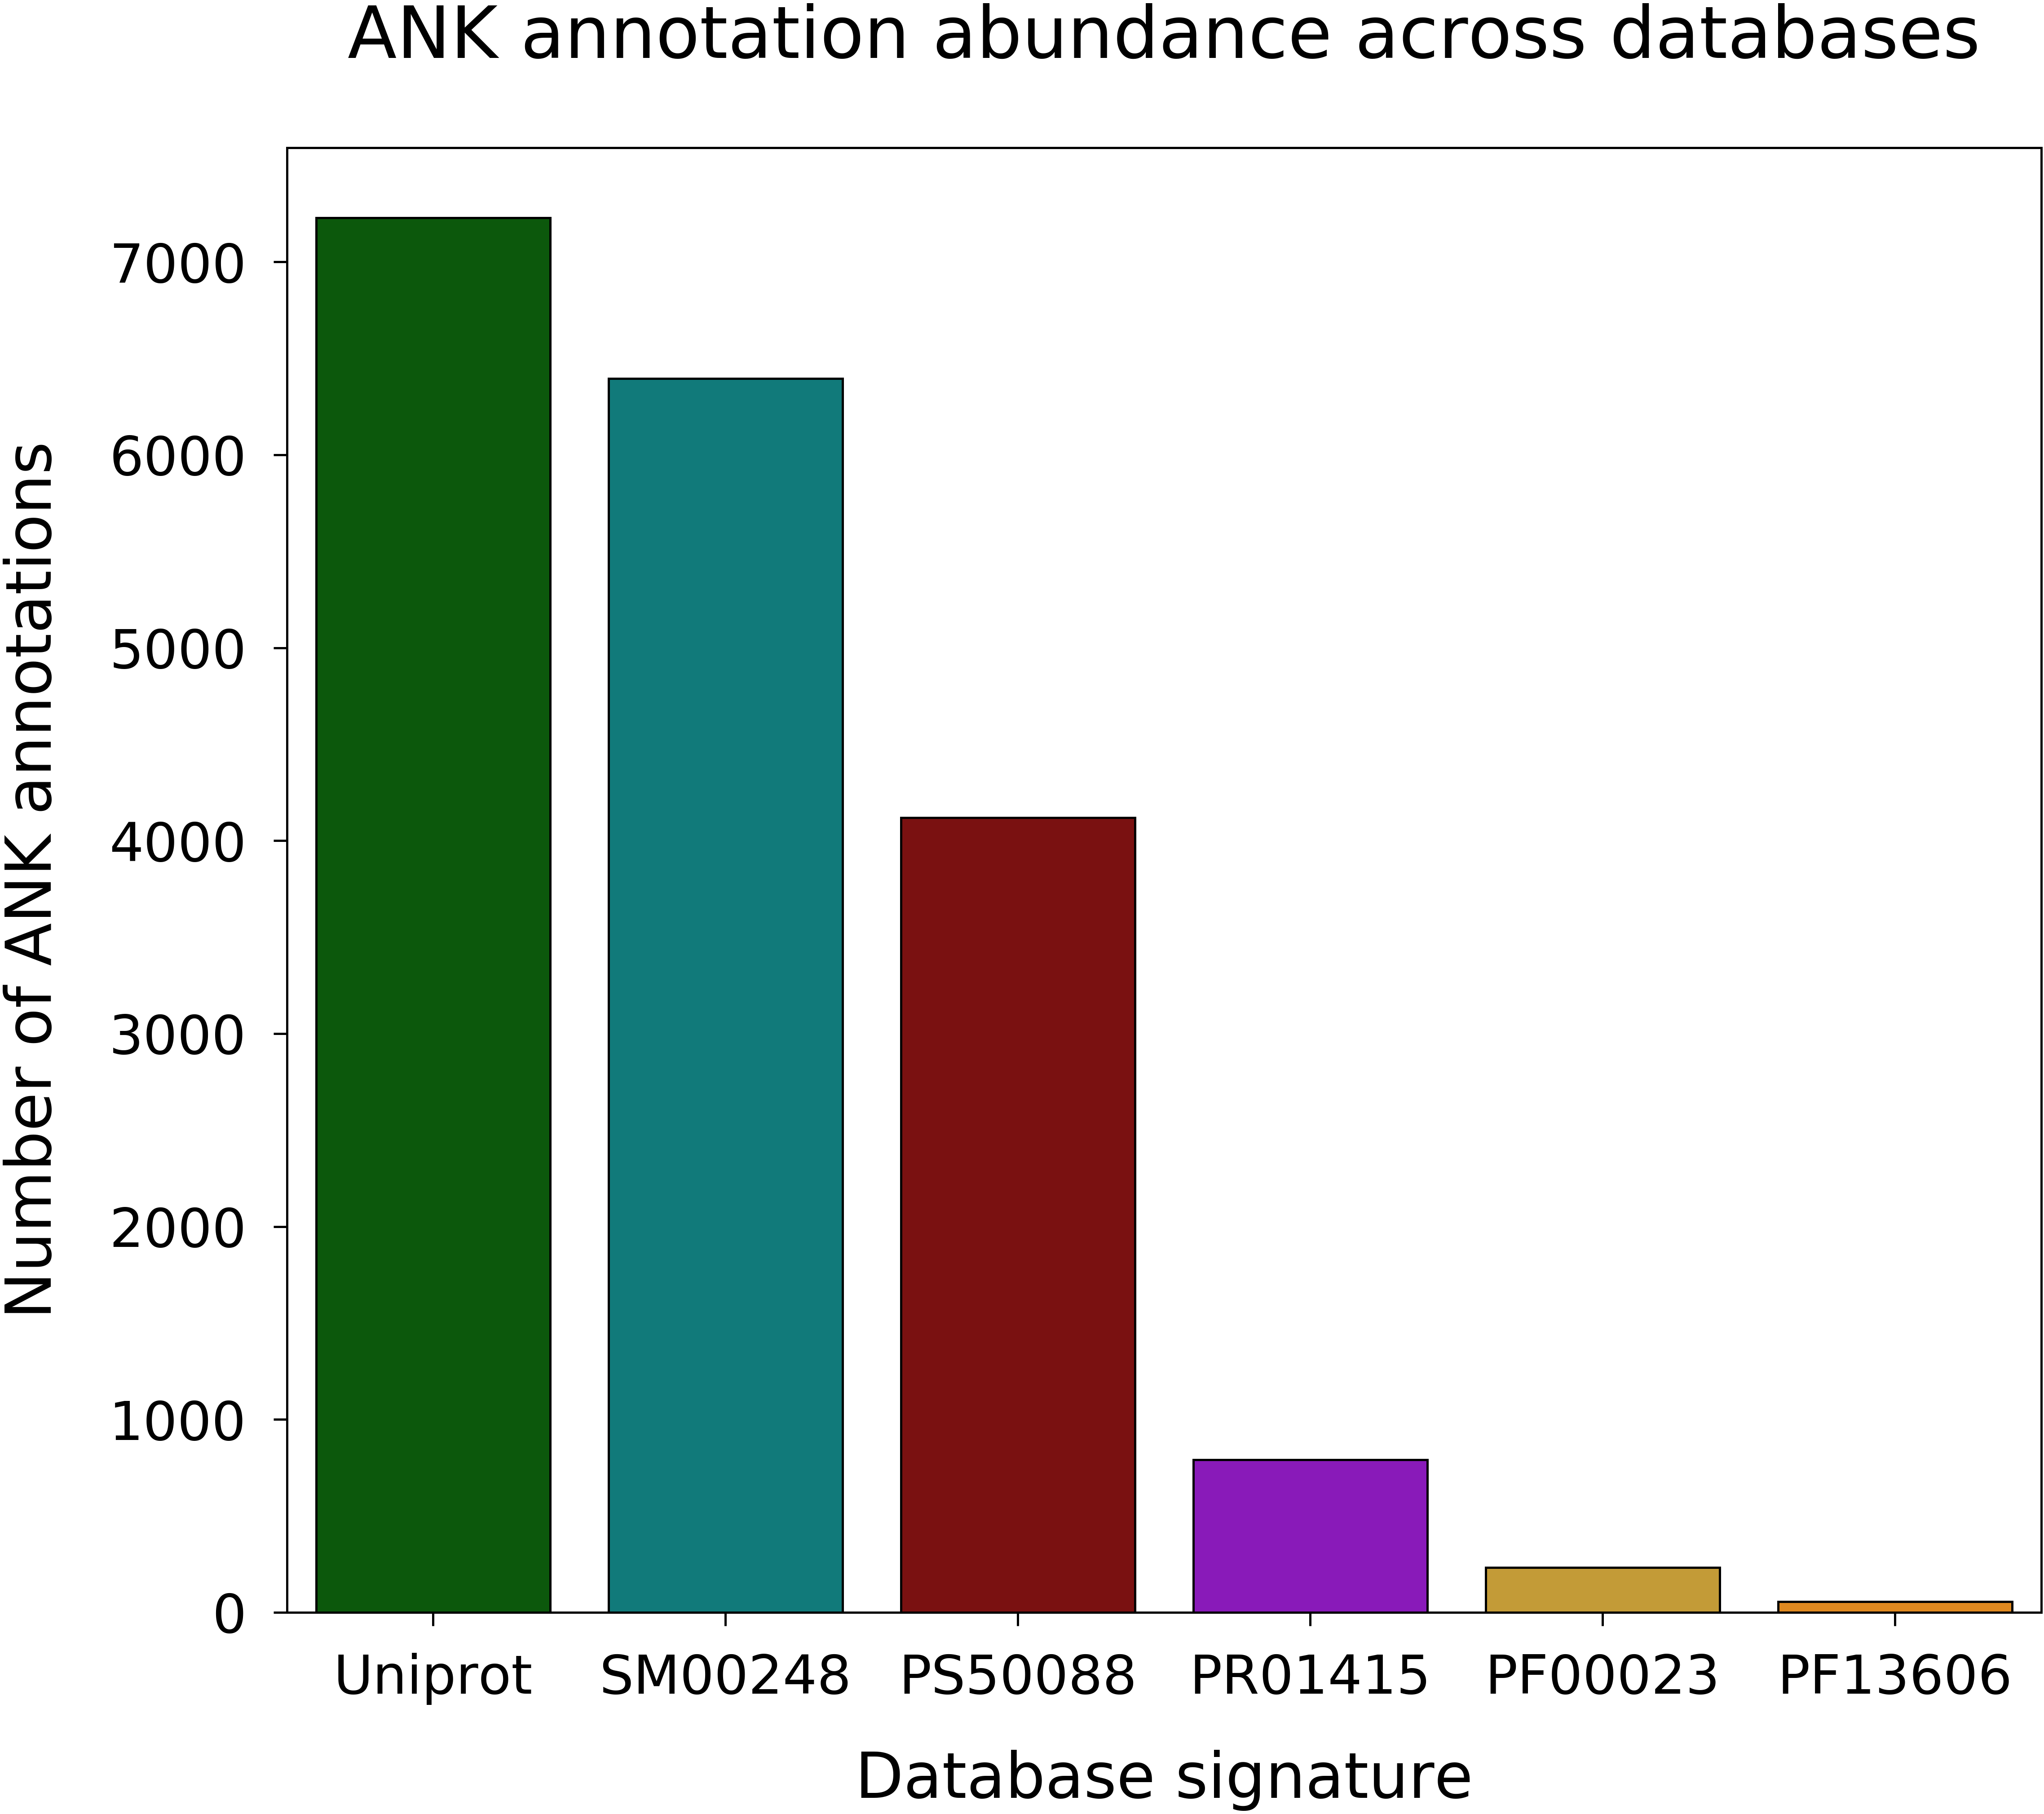

In [48]:
palette = {"SM00248": "darkcyan", "PS50088": "darkred", "Uniprot": "darkgreen", "PR01415": "darkviolet", "PF00023" :"goldenrod", 'PF13606':'darkorange'}
plt.figure(figsize=(70, 60))
plt.rcParams.update({"axes.linewidth": 5})
ax = sns.countplot(x = "source", data = master_df, edgecolor = "black", linewidth = 5, order = master_df["source"].value_counts().index, palette = palette)
ax.set_title("ANK annotation abundance across databases", pad = 200, fontsize = 160)
ax.set_xlabel("Database signature", labelpad = 100, fontsize = 140)
ax.tick_params(axis = "both" , which = "major", pad = 60, width = 5, length = 30, labelsize = 120)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_ylabel("Number of ANK annotations", labelpad = 100, fontsize = 140)
#plt.savefig('/homes/2394007/figures/def/anns_per_db_allsp.png')
plt.show()